In [ ]:
%pip install transformers accelerate bitsandbytes peft trl datasets huggingface_hub jupyterlab tqdm pandas scikit-learn torch
%pip install ipywidgets

In [ ]:
import os
from huggingface_hub import login

# Authenticate to Hugging Face (for pulling DeepSeek model weights)
login(
    token=os.getenv("HUGGINGFACE_TOKEN"),
    add_to_git_credential=False
)

print("HF login successful!")

In [ ]:
import os, re, torch, pandas as pd
from datasets import load_dataset, Dataset
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig, TrainingArguments
from peft import LoraConfig, get_peft_model
from trl import SFTTrainer
from tqdm.auto import tqdm

# Dataset definitions
DATASETS = [
  {"name": "mozilla", "train": "data/mozilla_full_version/train_all.jsonl", "test": "data/mozilla_full_version/test_all.csv"},
  {"name": "eclips", "train": "data/eclips_full_version/train_all.jsonl", "test": "data/eclips_full_version/test_all.csv"}
]


In [2]:
def make_prompt(issue_text: str) -> str:
    return (
        "Below is a GitHub issue. Suggest the single best developer "
        "(GitHub handle or email) to resolve it. Only return the identifier.\n\n"
        "### Issue:\n" + issue_text + "\n\n### Assignee:"
    )

def prepare_train(example):
    text = example["title"] + "\n\n" + example["body"]
    return {"text": text, "assignee": example["assignee"]}

def format_for_sft(example):
    prompt = make_prompt(example["text"])
    return {"text": prompt + " " + example["assignee"]}

def predict_assignee(model, tokenizer, issue_text: str) -> str:
    prompt = make_prompt(issue_text)
    inputs = tokenizer(prompt,
                       return_tensors="pt",
                       truncation=True,
                       max_length=MAX_SEQ_LENGTH-32).to(model.device)
    with torch.no_grad():
        out = model.generate(
            **inputs,
            max_new_tokens=16,
            temperature=0.1,
            top_k=1,
            top_p=0.0,
            num_return_sequences=1,
            do_sample=False,
        )
    decoded = tokenizer.decode(out[0], skip_special_tokens=True)
    return decoded.split("### Assignee:")[-1].strip().split()[0]

In [ ]:

import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

import torch
from datasets import load_dataset, Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    TrainingArguments,
    Trainer,
    set_seed,
)
from typing import Dict, List

DATASET     = {
    "name":       "mozilla",
    "train_file": "File_path",
    "test_file":  "File_path",
}
MODEL_NAME   = "deepseek-ai/DeepSeek-R1-Distill-Llama-8B"
MAX_SEQ_LEN  = 2048
LR           = 1e-5
EPOCHS       = 3
BATCH_PER_GPU= 1
GRAD_ACCUM   = 16
SEED         = 3407

set_seed(SEED)
torch.backends.cuda.matmul.allow_tf32 = True

def make_prompt(issue_text: str) -> str:
    return (
        "Below is a GitHub issue. Suggest the single best developer "
        "(GitHub handle or email) to resolve it. Only return the identifier.\n\n"
        "### Issue:\n" + issue_text + "\n\n### Assignee:"
    )

raw = load_dataset("json", data_files={"train": DATASET["train_file"]}, split="train")
print(f"• Train records: {len(raw)}")
print("• Sample raw entry:", raw[0], "\n")

def extract_pair(ex):
    msgs       = ex["messages"]
    user_msg   = next(m for m in msgs if m["role"] == "user")["content"]
    assist_msg = next(m for m in msgs if m["role"] == "assistant")["content"]
    return {"prompt": user_msg.strip(), "response": assist_msg.strip()}

mapped = raw.map(extract_pair, remove_columns=raw.column_names)
print(f"• After mapping, columns = {mapped.column_names}")
print("• Mapped sample:", mapped[0], "\n")

hf_train = Dataset.from_dict({
    "prompt":   [row["prompt"]   for row in mapped],
    "response": [row["response"] for row in mapped],
})
print(f"• Ready-to-train SFT examples: {len(hf_train)}\n")

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)
if tokenizer.pad_token_id is None:
    tokenizer.pad_token = tokenizer.eos_token

dtype = torch.bfloat16 if torch.cuda.is_available() and torch.cuda.is_bf16_supported() else torch.float16
model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    torch_dtype=dtype,
    device_map="auto",
)
model.gradient_checkpointing_enable()
model.config.use_cache = False

def tokenize_and_mask(batch: Dict[str, List[str]]):
    prompts  = [make_prompt(p) for p in batch["prompt"]]
    answers  = batch["response"]
    full_texts = [p + " " + a for p, a in zip(prompts, answers)]

    enc = tokenizer(
        full_texts,
        truncation=True,
        max_length=MAX_SEQ_LEN,
        padding=False,
        add_special_tokens=True,
    )
    enc_prompt = tokenizer(
        prompts,
        truncation=True,
        max_length=MAX_SEQ_LEN,
        padding=False,
        add_special_tokens=True,
    )

    labels = []
    for ids, p_ids in zip(enc["input_ids"], enc_prompt["input_ids"]):
        plen = min(len(p_ids), len(ids))
        lab = ids.copy()
        lab[:plen] = [-100] * plen  
        labels.append(lab)

    enc["labels"] = labels
    return enc

tok_train = hf_train.map(tokenize_and_mask, batched=True, remove_columns=hf_train.column_names)

def collate_fn(features):
    batch_ids  = [f["input_ids"] for f in features]
    batch_mask = [f["attention_mask"] for f in features]
    batch = tokenizer.pad(
        {"input_ids": batch_ids, "attention_mask": batch_mask},
        padding=True,
        return_tensors="pt",
    )
    max_len = batch["input_ids"].size(1)
    labels = []
    for f in features:
        lab = f["labels"]
        labels.append(torch.tensor(lab + [-100] * (max_len - len(lab)), dtype=torch.long))
    batch["labels"] = torch.stack(labels)
    return batch

training_args = TrainingArguments(
    output_dir=f"outputs/{DATASET['name']}_fullft",
    per_device_train_batch_size=BATCH_PER_GPU,
    gradient_accumulation_steps=GRAD_ACCUM,
    num_train_epochs=EPOCHS,       
    warmup_ratio=0.05,
    learning_rate=LR,
    lr_scheduler_type="cosine",
    weight_decay=0.01,
    bf16=(dtype==torch.bfloat16),
    fp16=(dtype==torch.float16),
    optim="adamw_torch",          
    logging_steps=50,
    save_strategy="epoch",
    save_total_limit=3,
    report_to="none",
)


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tok_train,
    data_collator=collate_fn,
)
trainer.train()

final_dir = f"outputs/{DATASET['name']}_fullft/final"
trainer.save_model(final_dir)
tokenizer.save_pretrained(final_dir)
print(f"✅ Saved full fine-tuned model and tokenizer to: {final_dir}")


/users/PCS0289/alirezzzhp1378/DeepseekR1_Bugtriage/venv/lib64/python3.9/site-packages/networkx/utils/backends.py:135: RuntimeWarning: networkx backend defined more than once: nx-loopback
  backends.update(_get_backends("networkx.backends"))


• Train records: 88373
• Sample raw entry: {'messages': [{'role': 'system', 'content': 'You are an expert GitHub bug triager. For each incoming issue, you will read the title and description, and choose exactly one assignee (email or name). Return only the assignee, with no extra words or punctuation.'}, {'role': 'user', 'content': 'Issue to triage:\nTitle: animated gif does not properly display\nBody: user agent mozilla windows nt rv gecko firefox build identifier mozilla windows nt rv gecko firefox some of the time the animated gif image on the referenced web site does display but it rarely displays in spite of frequent refresh when the web page is first loaded this problem never occurred in the older version of the browser reproducible sometimes steps to reproduce load page fresh hit refresh actual results animated gif seems more likely to display after page has been loaded for some time and less likely to display when page is first loaded from scratch expected results animated gif 

Map:   0%|          | 0/88373 [00:00<?, ? examples/s]

• After mapping, columns = ['prompt', 'response']
• Mapped sample: {'prompt': 'Issue to triage:\nTitle: animated gif does not properly display\nBody: user agent mozilla windows nt rv gecko firefox build identifier mozilla windows nt rv gecko firefox some of the time the animated gif image on the referenced web site does display but it rarely displays in spite of frequent refresh when the web page is first loaded this problem never occurred in the older version of the browser reproducible sometimes steps to reproduce load page fresh hit refresh actual results animated gif seems more likely to display after page has been loaded for some time and less likely to display when page is first loaded from scratch expected results animated gif should idsplay anytime page is loaded\nAssign to:', 'response': 'nobody@mozilla.org'} 

• Ready-to-train SFT examples: 88373



Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Map:   0%|          | 0/88373 [00:00<?, ? examples/s]

You're using a LlamaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss
50,3.803400
100,2.040800
150,1.580600
200,1.411200
250,1.253100
300,1.091300
350,0.972500
400,0.957900
450,0.867000
500,0.823400


✅ Saved full fine-tuned model and tokenizer to: outputs/mozilla_fullft/final


/users/PCS0289/alirezzzhp1378/DeepseekR1_Bugtriage/venv/lib64/python3.9/site-packages/networkx/utils/backends.py:135: RuntimeWarning: networkx backend defined more than once: nx-loopback
  backends.update(_get_backends("networkx.backends"))


Candidate space: 645 emails
Built prior list with 645 entries.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

🔧 Using checkpoint dir: outputs/mozilla_fullft/final
  • Found 4 weight shard(s), total size ≈ 14.96 GB
  • model.config._name_or_path = outputs/mozilla_fullft/final
  • dtype=torch.bfloat16, device=cuda:0
✅ Fine-tuned weights appear loaded from your local checkpoint.


FT: prompting k=1..10:   0%|          | 0/11048 [00:00<?, ?it/s]


Total test bugs: 11048


,top_k,n_hits,hit_ratio
0,1,8103,0.733
1,2,8586,0.777
2,3,8832,0.799
3,4,8944,0.810
4,5,9017,0.816
5,6,9100,0.824
6,7,9168,0.830
7,8,9208,0.833
8,9,9236,0.836
9,10,9270,0.839


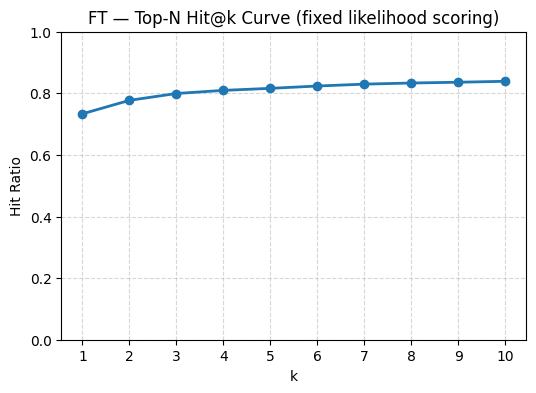

In [ ]:
# ─── FT MODEL: Single Top-10 prompting → Hit@K from one ranking (MOZILLA) ───
import os, re, json, glob
import torch
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from collections import Counter
from transformers import AutoTokenizer, AutoModelForCausalLM, GenerationConfig

DATASET = {
    "name":       "mozilla",
    "train_file": "File_path",
    "test_file":  "File_path",
}
FINETUNED_DIR = "FT File_path"

TOP_K       = 10
MAX_SEQ_LEN = 2048
USE_PRIOR_BACKFILL = True

PROGRESS_DIR  = f"outputs/{DATASET['name']}_eval_progress"
os.makedirs(PROGRESS_DIR, exist_ok=True)
PROGRESS_FILE = os.path.join(PROGRESS_DIR, "ft_top10_progress.jsonl")

test_df = pd.read_csv(DATASET["test_file"])
candidates = list(dict.fromkeys(test_df["assignee"].dropna().tolist()))
cand_lower2orig = {c.lower(): c for c in candidates}
cand_set_lower  = set(cand_lower2orig.keys())
print(f"Candidate space: {len(candidates)} emails")

prior_order = []
if USE_PRIOR_BACKFILL:
    cnt = Counter()
    try:
        with open(DATASET["train_file"], "r", encoding="utf-8") as f:
            for line in f:
                obj = json.loads(line)
                y = next(m for m in obj["messages"] if m["role"] == "assistant")["content"].strip()
                cnt[y] += 1
        freq_items = [(y, n) for y, n in cnt.items() if y in cand_lower2orig.values()]
        freq_items.sort(key=lambda t: t[1], reverse=True)
        prior_order = [y for y, _ in freq_items] + [c for c in candidates if c not in cnt]
        print(f"Built prior list with {len(prior_order)} entries.")
    except Exception as e:
        print(f"⚠️ Could not build prior ({e}); using alphabetical backfill.")
        prior_order = sorted(candidates)

tokenizer = AutoTokenizer.from_pretrained(FINETUNED_DIR, use_fast=True)
if tokenizer.pad_token_id is None:
    tokenizer.pad_token = tokenizer.eos_token

model = AutoModelForCausalLM.from_pretrained(
    FINETUNED_DIR,
    torch_dtype=(torch.bfloat16 if torch.cuda.is_available() else None),
    device_map="auto",
)
model.eval()

print(f"🔧 Using checkpoint dir: {FINETUNED_DIR}")
assert os.path.isdir(FINETUNED_DIR), f"Not a local directory: {FINETUNED_DIR}"

shards = sorted(glob.glob(os.path.join(FINETUNED_DIR, "model*.safetensors")))
total_gb = sum(os.path.getsize(p) for p in shards) / (1024**3)
print(f"  • Found {len(shards)} weight shard(s), total size ≈ {total_gb:.2f} GB")
print(f"  • model.config._name_or_path = {getattr(model.config, '_name_or_path', 'n/a')}")
print(f"  • dtype={getattr(model, 'dtype', 'n/a')}, device={model.device}")

if getattr(model.config, "_name_or_path", "") == "deepseek-ai/DeepSeek-R1-Distill-Llama-8B":
    print("⚠️ Looks like the BASE repo name; double-check FINETUNED_DIR.")
else:
    print("✅ Fine-tuned weights appear loaded from your local checkpoint.")

def make_prompt_top10(issue_text: str) -> str:
    k = 10
    return (
        f"Below is a GitHub issue. List the TOP {k} developers (emails only) to triage it, "
        f"ranked from best to worst. Use only emails known in this project; do not invent. "
        f"Return EXACTLY {k} comma-separated items, unique, with no extra text.\n\n"
        "Issue:\n" + issue_text + f"\n\nTop {k} assignees:"
    )

email_re = re.compile(r'[\w\.\+\-]+@[\w\.\-]+\.[A-Za-z]{2,}')

def parse_emails(text: str, k: int = 10) -> list[str]:
    found = email_re.findall(text)
    picked, seen = [], set()
    for em in found:
        key = em.lower()
        if key in cand_set_lower and key not in seen:
            picked.append(cand_lower2orig[key])
            seen.add(key)
            if len(picked) == k:
                break
    return picked

def backfill_to_n(current: list[str], n: int = 10) -> list[str]:
    if len(current) >= n:
        return current[:n]
    pool = prior_order if prior_order else sorted(candidates)
    for c in pool:
        if c not in current:
            current.append(c)
        if len(current) == n:
            break
    if len(current) < n:
        for c in candidates:
            if c not in current:
                current.append(c)
            if len(current) == n:
                break
    return current[:n]

gen_cfg = GenerationConfig.from_model_config(model.config)
gen_cfg.do_sample = False
gen_cfg.num_beams = 1
gen_cfg.eos_token_id = tokenizer.eos_token_id
gen_cfg.pad_token_id = tokenizer.pad_token_id
model.generation_config = gen_cfg

all_top10 = []
y_true = test_df["assignee"].tolist()

start_idx = 0
if os.path.exists(PROGRESS_FILE):
    restored = []
    with open(PROGRESS_FILE, "r", encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            try:
                obj = json.loads(line)
                restored.append(obj)
            except json.JSONDecodeError:
                continue
    if restored:
        restored.sort(key=lambda o: o.get("issue_index", 0))
        for obj in restored:
            if "top10" in obj and isinstance(obj["top10"], list) and len(obj["top10"]) == 10:
                all_top10.append(obj["top10"])
            elif "rank_k" in obj and isinstance(obj["rank_k"], list) and len(obj["rank_k"]) == TOP_K:
                all_top10.append(obj["rank_k"][-1])
        start_idx = len(all_top10)
        print(f"⏯️ Resumed from progress file: {start_idx}/{len(test_df)} issues already computed.")

for i, row in enumerate(tqdm(test_df.itertuples(index=False), total=len(test_df), desc="FT: prompting top-10 only")):
    if i < start_idx:
        continue

    issue = f"Title: {row.title}\n\n{row.body}"
    prompt = make_prompt_top10(issue)
    inputs = tokenizer(prompt, return_tensors="pt", truncation=True,
                       max_length=MAX_SEQ_LEN-64, padding=True).to(model.device)
    with torch.no_grad():
        out = model.generate(**inputs, max_new_tokens=200, do_sample=False, num_beams=1)[0]
    text = tokenizer.decode(out, skip_special_tokens=True)

    picked = parse_emails(text, k=10)
    top10_list = backfill_to_n(picked, n=10)
    all_top10.append(top10_list)

    entry = {"issue_index": i, "true": y_true[i], "top10": top10_list}
    with open(PROGRESS_FILE, "a", encoding="utf-8") as fw:
        fw.write(json.dumps(entry) + "\n")
        fw.flush()
        os.fsync(fw.fileno())

rows, N = [], len(test_df)
for k in range(1, TOP_K+1):
    hits = sum(y_true[i] in all_top10[i][:k] for i in range(N))
    rows.append({"top_k": k, "n_hits": hits, "hit_ratio": hits / N})
df_hits = pd.DataFrame(rows)

print(f"\nTotal test bugs: {N}")
display(df_hits.style.format({"hit_ratio": "{:.3f}"}).set_caption("🎯 FT — Hit@K from a single Top-10 prompt per issue (Mozilla)"))

plt.figure(figsize=(6,4))
plt.plot(df_hits["top_k"], df_hits["hit_ratio"], marker="o", linewidth=2)
plt.title("FT — Hit@k from Single Top-10 Ranking (Mozilla)")
plt.xlabel("k"); plt.ylabel("Hit Ratio"); plt.xticks(range(1, TOP_K+1)); plt.ylim(0,1)
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()


/users/PCS0289/alirezzzhp1378/DeepseekR1_Bugtriage/venv/lib64/python3.9/site-packages/networkx/utils/backends.py:135: RuntimeWarning: networkx backend defined more than once: nx-loopback
  backends.update(_get_backends("networkx.backends"))


Candidate space: 645 emails
Built prior list with 645 entries.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

🔧 Using base model repo: deepseek-ai/DeepSeek-R1-Distill-Llama-8B
  • model.config._name_or_path = deepseek-ai/DeepSeek-R1-Distill-Llama-8B
  • dtype=torch.bfloat16, device=cuda:0
✅ Base model appears loaded (not your fine-tuned checkpoint).
⏯️ Resumed from progress file: 6462/11048 issues already computed.


BASE: prompting k=1..10:   0%|          | 0/11048 [00:00<?, ?it/s]


Total test bugs: 11048


,top_k,n_hits,hit_ratio
0,1,8063,0.730
1,2,8234,0.745
2,3,8379,0.758
3,4,8466,0.766
4,5,8522,0.771
5,6,8578,0.776
6,7,8628,0.781
7,8,8666,0.784
8,9,8719,0.789
9,10,8775,0.794


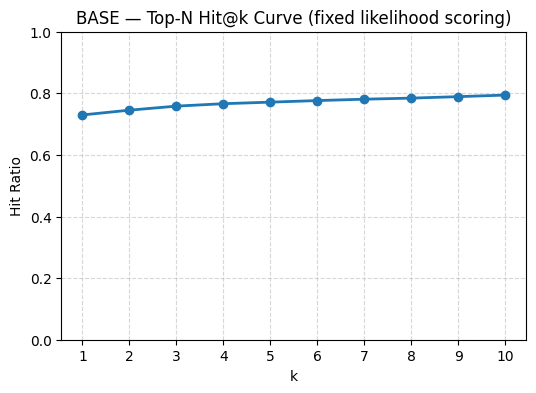

In [ ]:
# ─── BASE MODEL: Single Top-10 prompting → Hit@K from one ranking (MOZILLA) ─
import os, re, json, glob
import torch
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from collections import Counter
from transformers import AutoTokenizer, AutoModelForCausalLM, GenerationConfig

DATASET = {
    "name":       "mozilla",
    "train_file": "File_path",
    "test_file":  "File_path",
}
BASE_MODEL_NAME = "deepseek-ai/DeepSeek-R1-Distill-Llama-8B"

TOP_K       = 10
MAX_SEQ_LEN = 2048
USE_PRIOR_BACKFILL = True

PROGRESS_DIR  = f"outputs/{DATASET['name']}_eval_progress"
os.makedirs(PROGRESS_DIR, exist_ok=True)
PROGRESS_FILE = os.path.join(PROGRESS_DIR, "base_top10_progress.jsonl")

test_df = pd.read_csv(DATASET["test_file"])
candidates = list(dict.fromkeys(test_df["assignee"].dropna().tolist()))
cand_lower2orig = {c.lower(): c for c in candidates}
cand_set_lower  = set(cand_lower2orig.keys())
print(f"Candidate space: {len(candidates)} emails")

prior_order = []
if USE_PRIOR_BACKFILL:
    cnt = Counter()
    try:
        with open(DATASET["train_file"], "r", encoding="utf-8") as f:
            for line in f:
                obj = json.loads(line)
                y = next(m for m in obj["messages"] if m["role"] == "assistant")["content"].strip()
                cnt[y] += 1
        freq_items = [(y, n) for y, n in cnt.items() if y in cand_lower2orig.values()]
        freq_items.sort(key=lambda t: t[1], reverse=True)
        prior_order = [y for y, _ in freq_items] + [c for c in candidates if c not in cnt]
        print(f"Built prior list with {len(prior_order)} entries.")
    except Exception as e:
        print(f"⚠️ Could not build prior ({e}); using alphabetical backfill.")
        prior_order = sorted(candidates)

tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL_NAME, use_fast=True)
if tokenizer.pad_token_id is None:
    tokenizer.pad_token = tokenizer.eos_token

model = AutoModelForCausalLM.from_pretrained(
    BASE_MODEL_NAME,
    torch_dtype=(torch.bfloat16 if torch.cuda.is_available() else None),
    device_map="auto",
)
model.eval()

print(f"🔧 Using base model repo: {BASE_MODEL_NAME}")
print(f"  • model.config._name_or_path = {getattr(model.config, '_name_or_path', 'n/a')}")
print(f"  • dtype={getattr(model, 'dtype', 'n/a')}, device={model.device}")
if getattr(model.config, "_name_or_path", "") != BASE_MODEL_NAME:
    print("⚠️ Unexpected _name_or_path; double-check you're using the BASE model.")
else:
    print("✅ Base model appears loaded (not your fine-tuned checkpoint).")

def make_prompt_top10(issue_text: str) -> str:
    k = 10
    return (
        f"Below is a GitHub issue. List the TOP {k} developers (emails only) to triage it, "
        f"ranked from best to worst. Use only emails known in this project; do not invent. "
        f"Return EXACTLY {k} comma-separated items, unique, with no extra text.\n\n"
        "Issue:\n" + issue_text + f"\n\nTop {k} assignees:"
    )

email_re = re.compile(r'[\w\.\+\-]+@[\w\.\-]+\.[A-Za-z]{2,}')

def parse_emails(text: str, k: int = 10) -> list[str]:
    found = email_re.findall(text)
    picked, seen = [], set()
    for em in found:
        key = em.lower()
        if key in cand_set_lower and key not in seen:
            picked.append(cand_lower2orig[key])
            seen.add(key)
            if len(picked) == k:
                break
    return picked

def backfill_to_n(current: list[str], n: int = 10) -> list[str]:
    if len(current) >= n:
        return current[:n]
    pool = prior_order if prior_order else sorted(candidates)
    for c in pool:
        if c not in current:
            current.append(c)
        if len(current) == n:
            break
    if len(current) < n:
        for c in candidates:
            if c not in current:
                current.append(c)
            if len(current) == n:
                break
    return current[:n]

gen_cfg = GenerationConfig.from_model_config(model.config)
gen_cfg.do_sample = False
gen_cfg.num_beams = 1
gen_cfg.eos_token_id = tokenizer.eos_token_id
gen_cfg.pad_token_id = tokenizer.pad_token_id
model.generation_config = gen_cfg

all_top10 = []
y_true = test_df["assignee"].tolist()

start_idx = 0
if os.path.exists(PROGRESS_FILE):
    restored = []
    with open(PROGRESS_FILE, "r", encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            try:
                obj = json.loads(line)
                restored.append(obj)
            except json.JSONDecodeError:
                continue
    if restored:
        restored.sort(key=lambda o: o.get("issue_index", 0))
        for obj in restored:
            if "top10" in obj and isinstance(obj["top10"], list) and len(obj["top10"]) == 10:
                all_top10.append(obj["top10"])
        start_idx = len(all_top10)
        print(f"⏯️ Resumed from progress file: {start_idx}/{len(test_df)} issues already computed.")

for i, row in enumerate(tqdm(test_df.itertuples(index=False), total=len(test_df), desc="BASE: prompting top-10 only")):
    if i < start_idx:
        continue

    issue = f"Title: {row.title}\n\n{row.body}"
    prompt = make_prompt_top10(issue)
    inputs = tokenizer(prompt, return_tensors="pt", truncation=True,
                       max_length=MAX_SEQ_LEN-64, padding=True).to(model.device)
    with torch.no_grad():
        out = model.generate(**inputs, max_new_tokens=200, do_sample=False, num_beams=1)[0]
    text = tokenizer.decode(out, skip_special_tokens=True)

    picked = parse_emails(text, k=10)
    top10_list = backfill_to_n(picked, n=10)
    all_top10.append(top10_list)

    entry = {"issue_index": i, "true": y_true[i], "top10": top10_list}
    with open(PROGRESS_FILE, "a", encoding="utf-8") as fw:
        fw.write(json.dumps(entry) + "\n")
        fw.flush()
        os.fsync(fw.fileno())

rows, N = [], len(test_df)
for k in range(1, TOP_K+1):
    hits = sum(y_true[i] in all_top10[i][:k] for i in range(N))
    rows.append({"top_k": k, "n_hits": hits, "hit_ratio": hits / N})
df_hits = pd.DataFrame(rows)

print(f"\nTotal test bugs: {N}")
display(df_hits.style.format({"hit_ratio": "{:.3f}"}).set_caption("🎯 BASE — Hit@K from a single Top-10 prompt per issue (Mozilla)"))

plt.figure(figsize=(6,4))
plt.plot(df_hits["top_k"], df_hits["hit_ratio"], marker="o", linewidth=2)
plt.title("BASE — Hit@k from Single Top-10 Ranking (Mozilla)")
plt.xlabel("k"); plt.ylabel("Hit Ratio"); plt.xticks(range(1, TOP_K+1)); plt.ylim(0,1)
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()
